In [1]:
%run ../prophet/prophet_anomaly_detector.py

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Prophet anomaly detector loaded


/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


15605
14772
833
2 days, 21:25:00
0:00:16.917140


INFO:matplotlib.font_manager:findfont: Found a missing font file.  Rebuilding cache.
INFO:matplotlib.font_manager:font search path ['/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/fonts/ttf', '/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/fonts/afm', '/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/fonts/pdfcorefonts']


2005-07-28 13:55:00
2005-07-29 10:25:55
()
2005-06-07 07:00:00
0 days 00:04:59


INFO:matplotlib.font_manager:Could not open font file /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf
INFO:matplotlib.font_manager:generated new fontManager


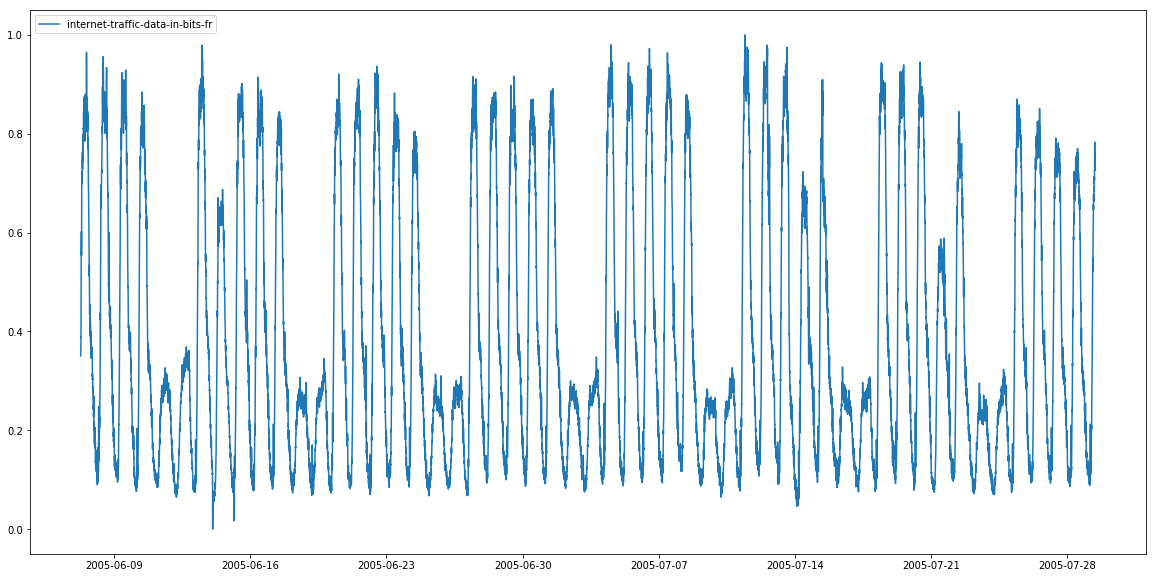

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, splitext, split
import json
from sklearn.preprocessing import MinMaxScaler
import datetime

def avg_time(datetimes):
    total = sum(dt.components.hours * 3600 * 1e9 + 
                dt.components.minutes * 60 * 1e9 + 
                dt.components.seconds * 1e9 +
                dt.components.milliseconds * 1e6 +
                dt.components.microseconds * 1e3 +
                dt.components.nanoseconds for dt in datetimes)
    avg = total / len(datetimes)
    seconds, _ = divmod(int(avg), 1e9)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return pd.Timedelta(hours=int(hours), minutes=int(minutes), seconds=int(seconds))

files = [
    #"../data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv",
    #"../data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv",
    #"../data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv",
    ##"../data/realAWSCloudwatch/ec2_cpu_utilization_77c1ca.csv",
    ##"../data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv",
    ##"../data/realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv",
    ##"../data/realAWSCloudwatch/ec2_cpu_utilization_c6585a.csv",
    #"../data/realAWSCloudwatch/ec2_cpu_utilization_fe7f93.csv",
    #"../data/realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv",
    ##"../data/realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv",
    ##"../data/realAWSCloudwatch/ec2_network_in_257a54.csv",
    #"../data/realAWSCloudwatch/ec2_network_in_5abac7.csv",
    ##"../data/realAWSCloudwatch/elb_request_count_8c0756.csv",
    #"../data/realAWSCloudwatch/grok_asg_anomaly.csv",
    #"../data/realAWSCloudwatch/iio_us-east-1_i-a2eb1cd9_NetworkIn.csv",
    #"../data/realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv",
    ##"../data/realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv"
    
    #"../data/artificialWithAnomaly/art_daily_jumpsup.csv"
    "../../anomaly-detection/internet_traffic/data/internet-traffic-data-in-bits-fr.csv"
]

out_names = []
dfs = []
label_names = []
earliest_start_time = None
latest_stop_time = None
time_diffs = []

for file in files:
    df = pd.read_csv(file, header=0, names=["ds", "y"], 
                 parse_dates=True, index_col=0)    
        
    x = df.values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(data=x_scaled,
                     index=df.index,
                     columns=['y'])
    
    dfs.append(df)
    
    least_recent_date = df.index.min()
    recent_date = df.index.max()
    if not earliest_start_time or least_recent_date < earliest_start_time:
        earliest_start_time = least_recent_date
    if not latest_stop_time or recent_date > latest_stop_time:
        latest_stop_time = recent_date
    time_diffs.append((recent_date - least_recent_date) / len(df))
    
    name_w_ending = basename(file)
    name = splitext(name_w_ending)[0]
    out_names.append(name)
    file_name = split(file)[-1]
    package_name = split(split(file)[0])[-1]
    label_names.append(package_name + "/" + file_name)

new_index = pd.date_range(start=earliest_start_time, end='2005-07-31 11:20:00', freq="5T")
print(len(new_index))
print(len(dfs[0]))
missing =len(new_index) - len(dfs[0])

print(missing)
missing_time = missing * datetime.timedelta(minutes=5)
print(missing_time)

stretch = missing_time / len(dfs[0])
print(stretch)


indexes = dfs[0].index.tolist()
new_df = pd.DataFrame(columns=["y"])
for i, time in enumerate(indexes):
    a = dfs[0].at[time, "y"]
    #dfs[0] = dfs[0].drop(time)
    new_time = time + datetime.timedelta(seconds=5) * i
    new_df.loc[new_time] = [a]
dfs[0] = new_df
    

dfs[0]["ds"] = dfs[0].index
print(latest_stop_time)
print(dfs[0].index.max())
print()
print(earliest_start_time)

diff = avg_time(time_diffs)
print(diff)

plt.figure(figsize=(20,10))

for i, df in enumerate(dfs):
    plt.plot(df["ds"], df["y"], label=out_names[i])

plt.legend(loc='upper left')
plt.show()

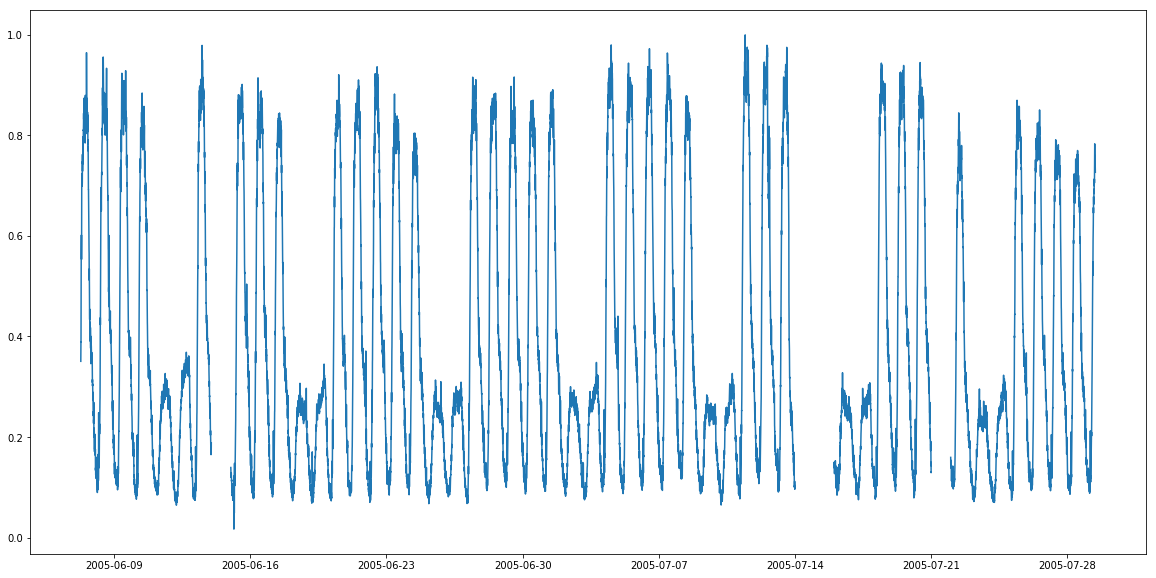

In [4]:
df = dfs[0].copy()

data = df.copy()
# Remove outliers
df.loc[(df['ds'] > '2005-06-14') & (df['ds'] < '2005-06-15'), 'y'] = None
df.loc[(df['ds'] > '2005-07-14') & (df['ds'] < '2005-07-16'), 'y'] = None
df.loc[(df['ds'] > '2005-07-21') & (df['ds'] < '2005-07-22'), 'y'] = None
plt.figure(figsize=(20,10))
plt.plot(df["ds"], df["y"])
plt.show()

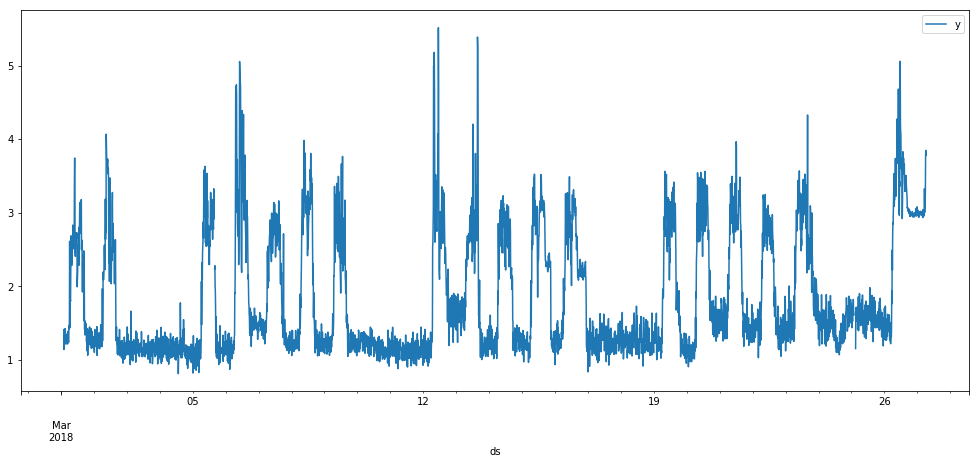

In [2]:
%matplotlib inline
#import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("Data/metrics_26_days.csv", header=None,
                      names=["ds", "y"], index_col=0, parse_dates=True)

df['y'] = np.log(df['y'])
df = df.resample("10T").mean()
df["ds"] = df.index
b
# Store this data for later use before removing outliers
data = df.copy()

# Plot the data
df.plot(x="ds", y="y", figsize=(17,7))

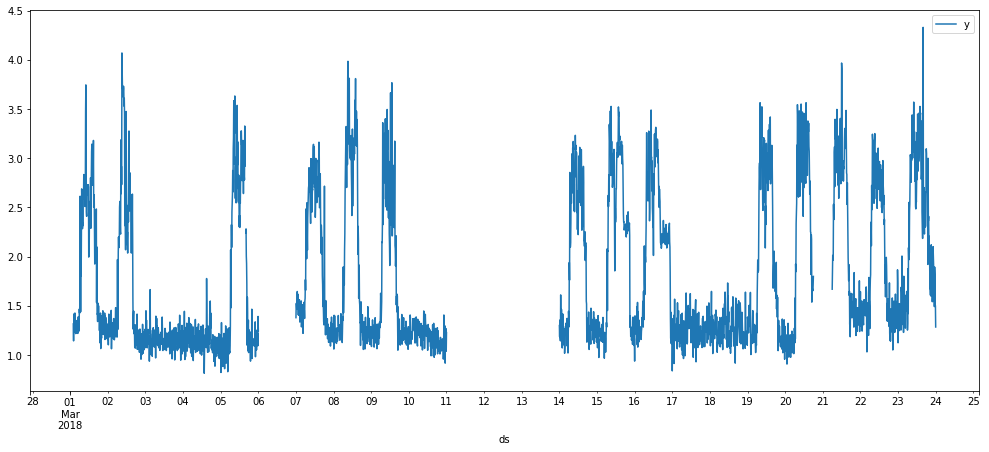

In [3]:
# Remove outliers
df.loc[(df['ds'] > '2018-03-06') & (df['ds'] < '2018-03-07'), 'y'] = None
df.loc[(df['ds'] > '2018-03-11') & (df['ds'] < '2018-03-12'), 'y'] = None
df.loc[(df['ds'] > '2018-03-12') & (df['ds'] < '2018-03-14'), 'y'] = None
df.loc[(df['ds'] > '2018-03-20T18') & (df['ds'] < '2018-03-21T06'), 'y'] = None
df.loc[(df['ds'] > '2018-03-24') & (df['ds'] < '2018-03-28'), 'y'] = None
df.plot(x="ds", y="y", figsize=(17,7))

No filtered data, using raw data
Building data model...  Done in 69.219201088 s
Forecasting data...  Done in 138.087357044 s
Getting standard deviation...  Done in 2.92975497246 s
Building standard deviation model...  Done in 1.0195441246 s
Forecasting standard deviation...  Done in 14.0552580357 s
Filling points...  Done in 1.69642210007 s
Anomalies between 2005-06-13 11:31:05  -  2005-06-13 16:41:10
Anomalies between 2005-06-14 08:31:45  -  2005-06-14 17:35:40
Anomalies between 2005-06-24 13:58:10  -  2005-06-24 18:02:10
Anomalies between 2005-07-04 12:43:00  -  2005-07-04 16:52:05
Anomalies between 2005-07-05 00:14:20  -  2005-07-05 05:54:55
Anomalies between 2005-07-13 14:47:30  -  2005-07-13 22:25:00
Anomalies between 2005-07-14 08:24:50  -  2005-07-14 16:53:10
Anomalies between 2005-07-14 21:53:05  -  2005-07-15 10:05:05
Anomalies between 2005-07-15 11:26:25  -  2005-07-15 16:46:40
Anomalies between 2005-07-21 05:42:25  -  2005-07-21 15:57:30
Anomalies between 2005-07-22 02:07:30

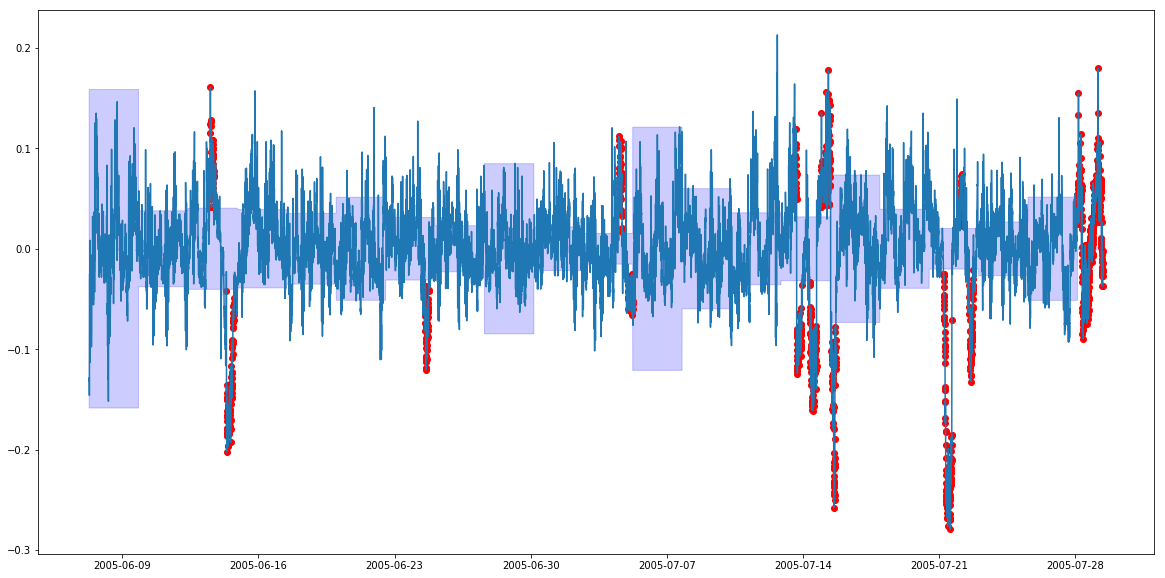

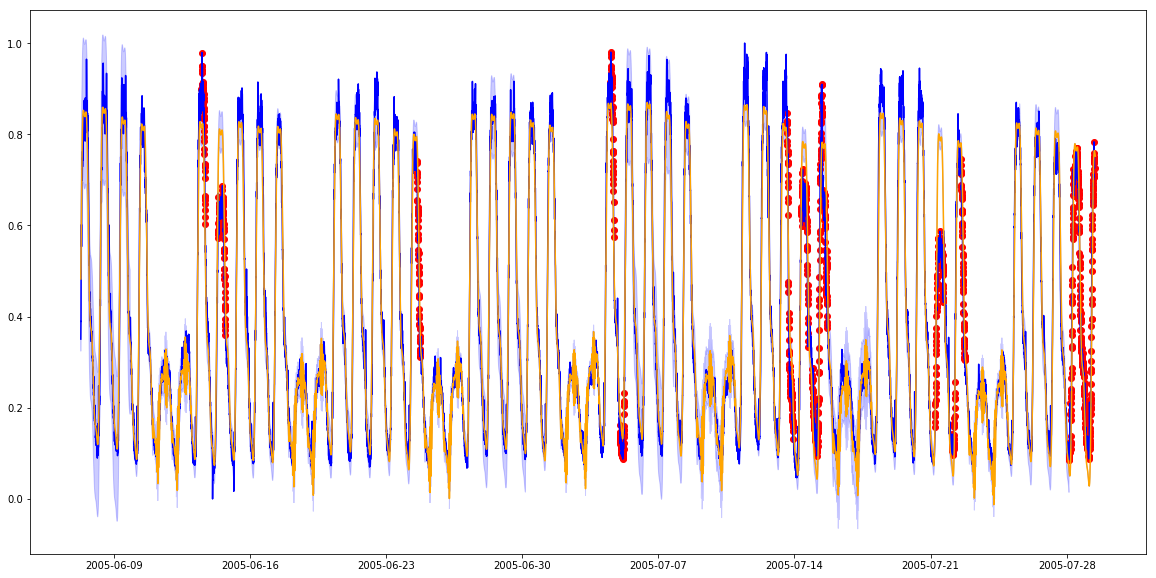

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'datetime.time'

In [6]:
start = time.time() 
calculate_anomalies(data)
elapsed = time.time()
elapsed = elapsed - start
print("Time spent: ", elapsed)